In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Hyperparameter Tuning

This notebook was made in order to give a brief introduction to hyperparameter tuning. A comparison between the most basic algorithms is shown. 

In [1]:
!pip install keras-tuner==1.0.2 aisaratuners==1.4.3

     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 13.2MB 249kB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=9333ab183934522824acd0da79e54ae047a6dbe363607ea0043cf29bd7c3b3b6
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15357 sha256=288ff03f86e0450e21b85b71c42bfae4d869d4e099bb9c8124fe2ce8f59656b5
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
import time
import tensorflow as tf
import kerastuner as kt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing

In [3]:
# Import dataset
# from tensorflow.keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Preprocessing
# x_train = np.expand_dims(x_train, axis=3).astype('float32')/255.0
# x_test = np.expand_dims(x_test, axis=3)/255.0
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

170500096/170498071 [==============================] - 4s 0us/step


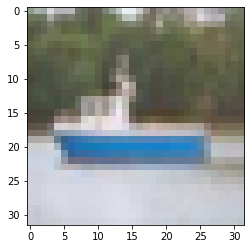

label: [8]
input shape: 32 by 32


In [4]:
random_sample_idx =  np.random.randint(0, len(x_train)-1)
# plt.imshow(x_train[random_sample_idx], cmap='gray')
plt.imshow(x_train[random_sample_idx])
plt.show()
print(f'label: {y_train[random_sample_idx]}')
print(f'input shape: {len(x_train[0])} by {len(x_train[0][0])}')

## Model Definition
A simple classification model based on Convolutional Neuronal Networks will be used. It consists of three Convolutional layers with ReLU activations, MaxPooling and dropout regularization for encoding the image, and a two-layered Fully-Connected Network for classifying.

In [5]:
# Setting Environment
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,Dense, Dropout, Flatten, MaxPooling2D

physical_devices = tf.config.experimental.list_physical_devices("GPU")
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

INPUT_SHAPE = x_train[0].shape
NUM_CLASSES = 10
EPOCHS = 25
SEED = 37

np.random.seed(SEED)

## Baseline Performance

In [6]:
# Model Definition
tf.random.set_seed(SEED)
model = keras.Sequential()
model.add(
    Conv2D(
        filters=8,
        kernel_size=3,
        activation='relu',
        input_shape=INPUT_SHAPE
    )
)
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.25))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

### Training Baseline

In [7]:
start_t = time.time()
model.fit(x_train, y_train, epochs=EPOCHS, validation_split=0.1)
end_t = time.time()

Epoch 1/25
1407/1407 [==============================] - 5s 3ms/step - loss: 1.6596 - accuracy: 0.3851 - val_loss: 1.4066 - val_accuracy: 0.5016
Epoch 2/25
1407/1407 [==============================] - 5s 3ms/step - loss: 1.3508 - accuracy: 0.5131 - val_loss: 1.1472 - val_accuracy: 0.6028
Epoch 3/25
1407/1407 [==============================] - 5s 3ms/step - loss: 1.2256 - accuracy: 0.5611 - val_loss: 1.0963 - val_accuracy: 0.6146
Epoch 4/25
1407/1407 [==============================] - 5s 3ms/step - loss: 1.1297 - accuracy: 0.5981 - val_loss: 0.9951 - val_accuracy: 0.6496
Epoch 5/25
1407/1407 [==============================] - 5s 3ms/step - loss: 1.0647 - accuracy: 0.6214 - val_loss: 0.9191 - val_accuracy: 0.6740
Epoch 6/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.0103 - accuracy: 0.6438 - val_loss: 0.9185 - val_accuracy: 0.6768
Epoch 7/25
1407/1407 [==============================] - 5s 3ms/step - loss: 0.9805 - accuracy: 0.6526 - val_loss: 0.8734 - val_accuracy:

### Baseline Performance

In [8]:
base_loss, base_accuracy = model.evaluate(x_test, y_test)
base_elapsed_time = end_t - start_t
print(f"Elapsed time (s): {base_elapsed_time:0.2f} (s)")
print(f'Baseline loss: {base_loss:0.3f}, accuracy: {base_accuracy:0.3f}%')

313/313 [==============================] - 1s 2ms/step - loss: 0.7810 - accuracy: 0.7349
Elapsed time (s): 122.53 (s)
Baseline loss: 0.781, accuracy: 0.735%


## Classical Hyperparameter Tuning tools

### Model Definition

In [9]:
from kerastuner import HyperModel

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(
            Conv2D(
                filters=16,
                kernel_size=3,
                activation="relu",
                input_shape=self.input_shape,
            )
        )
        model.add(Conv2D(16, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(
                rate=hp.Float(
                    "dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,
                )
            )
        )
        model.add(
            Conv2D(
                filters=hp.Choice("num_filters", values=[16, 32, 64, 128], default=32,),
                activation="relu",
                kernel_size=3,
            )
        )
        model.add(MaxPooling2D(pool_size=2))
        model.add(
            Dropout(
                rate=hp.Float(
                    "dropout_2", min_value=0.0, max_value=0.5, default=0.25, step=0.05,
                )
            )
        )
        model.add(Flatten())
        model.add(
            Dense(
                units=hp.Int(
                    "units", min_value=32, max_value=512, step=16, default=128
                ),
                activation=hp.Choice(
                    "dense_activation",
                    values=["relu", "tanh", "sigmoid"],
                    default="relu",
                ),
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(
                    "dropout_3", min_value=0.0, max_value=0.5, default=0.25, step=0.05
                )
            )
        )
        model.add(Dense(self.num_classes, activation="softmax"))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    "learning_rate",
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling="LOG",
                    default=1e-3,
                )
            ),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

In [10]:
# Environmental Variables
from pathlib import Path
from kerastuner.tuners import BayesianOptimization, Hyperband, RandomSearch

model = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

output_dir = Path("./output/cifar10/")
project_name = "simple_cnn_model_tuning"
HYPERBAND_MAX_EPOCHS = 25
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2
BAYESIAN_NUM_INITIAL_POINTS = 1

### Tuner definitions

In [11]:
tuners = [
    RandomSearch(
        model,
        objective="val_accuracy",
        seed=SEED,
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTION_PER_TRIAL,
        directory=f"{output_dir}_random_search",
        project_name=project_name,
    ),
    Hyperband(
        model,
        max_epochs=HYPERBAND_MAX_EPOCHS,
        objective="val_accuracy",
        seed=SEED,
        executions_per_trial=EXECUTION_PER_TRIAL,
        directory=f"{output_dir}_hyperband",
        project_name=project_name,
    ),
    BayesianOptimization(
        model,
        objective='val_accuracy',
        seed=SEED,
        num_initial_points=BAYESIAN_NUM_INITIAL_POINTS,
        max_trials=MAX_TRIALS,
        directory=f"{output_dir}_bayesian",
        project_name=project_name
    )
]

### Tuner Workflow

In [12]:
def tuner_workflow(tuner, x_train, y_train, x_test, y_test):
    tuner.search_space_summary()
    search_start = time.time()
    tuner.search(x_train, y_train, epochs=EPOCHS, validation_split=0.1)
    search_end = time.time()
    elapsed_time = search_end - search_start

    # Show a summary of the search
    tuner.results_summary()

    # Retrieve the best model.
    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluate the best model.
    loss, accuracy = best_model.evaluate(x_test, y_test)
    return elapsed_time, loss, accuracy

In [13]:
results = [[base_elapsed_time, base_loss, base_accuracy]]
for tuner in tuners:
    elapsed_time, loss, accuracy = tuner_workflow(
        tuner, x_train, y_train, x_test, y_test
    )
    results.append([elapsed_time, loss, accuracy])

Trial 20 Complete [00h 01m 58s]
val_accuracy: 0.7128000259399414

Best val_accuracy So Far: 0.7638000249862671
Total elapsed time: 00h 42m 13s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in output/cifar10_bayesian/simple_cnn_model_tuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 128
dropout_2: 0.5
units: 512
dense_activation: relu
dropout_3: 0.2
learning_rate: 0.0001
Score: 0.7638000249862671
Trial summary
Hyperparameters:
dropout_1: 0.30000000000000004
num_filters: 128
dropout_2: 0.2
units: 512
dense_activation: relu
dropout_3: 0.2
learning_rate: 0.0001
Score: 0.7580000162124634
Trial summary
Hyperparameters:
dropout_1: 0.15000000000000002
num_filters: 128
dropout_2: 0.5
units: 512
dense_activation: relu
dropout_3: 0.0
learning_rate: 0.0001
Score: 0.7563999891281128
Trial summary
Hyperparameters:
dropout_1: 0.0
num_filters: 128
dropout_2: 0.0
units: 512
dense_activation: relu
drop

In [14]:
# Save results
import pickle
with open('./output/tuners.pk', 'wb') as f:
    pickle.dump(tuners, f)

## AI Driven Hyperparameter Tuning tools
### Model Definition

In [15]:
def hypermodel_func(hyperparams, trial):
    tf.random.set_seed(SEED)
    model = keras.Sequential()
    model.add(
        Conv2D(
            filters=8,
            kernel_size=3,
            activation='relu',
            input_shape=INPUT_SHAPE
        )
    )
    model.add(Conv2D(16, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(rate=hyperparams['dropout_1'][trial]))
    model.add(Conv2D(filters=hyperparams['num_filters'][trial], kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(rate=hyperparams['dropout_2'][trial]))
    model.add(Flatten())
    model.add(Dense(
        units=hyperparams['units'][trial], 
        activation='relu'
    ))
    model.add(Dropout(rate=hyperparams['dropout_3'][trial]))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(
            optimizer=keras.optimizers.Adam(hyperparams['learning_rate'][trial]),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
    history = model.fit(x_train, y_train, epochs=EPOCHS, validation_split=0.1)
    return model, history          

### Hyperparams ranges

In [16]:
from aisaratuners import aisara_keras_tuner as akt

hyperparams = akt.Hp()
hyperparams.numrange(name='dropout_1', min=0.0, max=0.5)
hyperparams.numrange(name='num_filters', min=16, max=128)
hyperparams.numrange(name='dropout_2', min=0.0, max=0.5)
hyperparams.numrange(name='units', min=32, max=512)
hyperparams.numrange(name='dropout_3', min=0.0, max=0.5)
hyperparams.numrange(name='learning_rate', min=1e-4, max=1e-2, type='log')

0.0001

### Tuner configuration

In [17]:
tuner = akt.HpOptimization(
    hyperparams, 
    hypermodel_func, 
    ['val_accuracy', 'val_loss'], 
    ['max', 'min'], 
    num_trials=5, 
    rounds=3,
    mode='p',
    aisara_seed='fixed'
)

### Tuning job

In [18]:
start_t = time.time()
tuner.run_opti()
end_t = time.time()

For commercial use, you can obtain our API from https://rapidapi.com/aisara-technology-aisara-technology-default/api/aisara-hyperparameter-tuning
If you are a private user, set the mode parameter in HpOptimization class to "p".


Round-1:

  Run-1:
Epoch 1/25
1407/1407 [==============================] - 5s 3ms/step - loss: 1.7004 - accuracy: 0.3674 - val_loss: 1.4336 - val_accuracy: 0.4648
Epoch 2/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.4007 - accuracy: 0.4986 - val_loss: 1.3410 - val_accuracy: 0.5162
Epoch 3/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.2905 - accuracy: 0.5421 - val_loss: 1.2949 - val_accuracy: 0.5520
Epoch 4/25
1407/1407 [==============================] - 5s 3ms/step - loss: 1.2217 - accuracy: 0.5666 - val_loss: 1.2923 - val_accuracy: 0.5440
Epoch 5/25
1407/1407 [==============================] - 4s 3ms/step - loss: 1.1814 - accuracy: 0.5808 - val_loss: 1.2745 - val_accuracy: 0.5550
Epoch 6/25
1407/1407 [=========

### AI Tuner performance

In [27]:
ai_best_model = tuner.best_model
ai_loss, ai_accuracy = ai_best_model.evaluate(x_test, y_test)
ai_elapsed_time = end_t - start_t
print(f"Elapsed time (s): {ai_elapsed_time:0.2f} (s)")
print(f'AI Tuner Best model loss: {ai_loss:0.3f}, accuracy: {ai_accuracy:0.3f}%')
results.append([ai_elapsed_time, ai_loss, ai_accuracy])

313/313 [==============================] - 1s 3ms/step - loss: 1.9308 - accuracy: 0.1020
Elapsed time (s): 2149.78 (s)
AI Tuner Best model loss: 1.931, accuracy: 0.102%


In [29]:
for result in results[0:5]:
  print(result)

[122.52753019332886, 0.7809739112854004, 0.7348999977111816]
[4663.7847492694855, 0.7547946572303772, 0.7552000284194946]
[2718.407343149185, 0.7292322516441345, 0.7501999735832214]
[2533.7225046157837, 0.742324709892273, 0.7457000017166138]
[2149.7841844558716, 1.930823802947998, 0.10199999809265137]
